In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import GPy
import scipy
# Pytorch
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from torchvision.utils import make_grid
from tqdm import tqdm, trange
plt.style.use('ggplot')

In [9]:
class Dropout_MLP(nn.Module):
    """
    Creates an object of a Neural Network with dropuout rate, specified number of layers and units.

    Methods
    -------
    forward(x):
        Computes forward propagation of the network
    """

    def __init__(self, n_input, n_output, n_layers, n_units, dropout_prob,
                 sigma_noise, sigma_prior=0.1, fit_noise=False):
        """
        Parameters
        ----------
        n_input : int
            Size of input feature space
        n_outputs : int
            Number of output nodes
        n_layers : int
            Number of layers
        n_units : int
            Number of units in each layer (equal for all layers)
        dropout_prop : float
            Dropout probability
        sigma_prior: float
            Variance of data noise.
        """
        super(Dropout_MLP, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_layers = n_layers
        self.dropout = dropout_prob
        # IDefine the layers
        self.layers = nn.ModuleDict(OrderedDict(
            {
                # input-hidden weights
                "l_input": nn.Linear(self.n_input, n_units),
                # hidden-hidden weights
                "l_hidden": nn.Linear(n_units, n_units),
                # hidden-output weights
                "l_out": nn.Linear(n_units, self.n_output)
            }))

        if fit_noise:
            self.sigma_noise = nn.Parameter(torch.tensor([sigma_noise]), requires_grad=True)
        else:
            self.sigma_noise = torch.tensor([sigma_noise])
        # Initalize the weights
        for layer in self.layers:
            if type(self.layers[layer]) == nn.Linear:
                torch.nn.init.kaiming_uniform_(self.layers[layer].weight)
                # torch.nn.init.xavier_normal_(self.layers[layer].weight)
                # torch.nn.init.normal_(self.layers[layer].weight, 0.0, sigma_prior)
                # torch.nn.init.uniform_(self.layers[layer].bias, a=-1.0, b=1.0)
        self.activation = nn.ReLU()

    def forward(self, x):
        """Computes forward propagation of the network"""
        x = Variable(torch.Tensor(x))
        x = x.view(-1, self.n_input)
        for layer in range(self.n_layers):
            if layer == 0:
                # Inpute layer
                output = self.layers["l_input"](x)
                output = self.activation(output)
                output = F.dropout(output, p=self.dropout, training=True)
            else:
                # Hidden layer
                output = self.layers["l_hidden"](output)
                output = self.activation(output)
                output = F.dropout(output, p=self.dropout, training=True)
        # Output layer                       
        output = self.layers["l_out"](output)
        return output

In [10]:
class MC_Dropout_fit:
    """Fits a Bayesian Neural Network with specified parameters"""

    def __init__(self, n_input, n_output, n_layers, n_units, learn_rate, dropout_prob,
                 weight_decay, sigma_noise, batch_size, n_batches, fit_noise=False):
        """
        
        Parameters
        ----------
        n_input : int
            Size of input feature space
        n_outputs : int
            Number of output nodes
        n_layers : int
            Number of layers
        n_units : int
            Number of units in each layer (equal for all layers)
        learn_rate : float
            learning rate
        dropout_prop : float
            Dropout probability
        weight_decay : float
            weight decay (l2 regularization)
        sigma_noise : float
            variance of the data noise
        batch_size : int
            size of the batch
        n_batches : int
            number of batches
        fit_noise : bool
            if wanted, noise can be learned from data
        """
        # Soecify training parameters
        self.batch_size = batch_size
        self.n_batches = n_batches
        # Create a neural network object
        self.network = Dropout_MLP(n_input=n_input, n_output=n_output, n_layers=n_layers,
                                   n_units=n_units, dropout_prob=dropout_prob,
                                   sigma_noise=sigma_noise, sigma_prior=1.0, fit_noise=fit_noise)
        # Create an optimizer object
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate,
                                         weight_decay=weight_decay)
        self.train_loss = []

    def fit(self, x, y):
        """Trains a Bayesian Neural Network"""
        X = Variable(torch.Tensor(x))
        y = Variable(torch.Tensor(y))
        # Clear the optimzer gradients
        self.optimizer.zero_grad()
        output = self.network(X)
        # Compute total loss 
        loss = self.log_likelihood(y, output).sum() / float(self.batch_size)
        # Optimize loss and adjust weights
        loss.backward()
        self.optimizer.step()
        return loss

    def log_likelihood(self, x, mu):
        """Computes negative log-likelihood loss"""
        sigma = - torch.log(torch.abs(torch.tensor([self.network.sigma_noise])))
        exponent = -(x - mu) ** 2 / (2 * self.network.sigma_noise ** 2)
        log_lik = exponent + sigma
        return -log_lik

In [36]:
def plot_BBP(x_train, y_train, x_test, y_test, train_pred, test_pred, 
             aleatoric_train, epistemic_train, total_unc_train,
             aleatoric_test, epistemic_test, total_unc_test):
    
    """Plots predictions on training and test sets together with uncertainty"""
    
    plt.figure(figsize=(12, 15))
    # Training set
    ax = plt.subplot(2, 1, 1)
    # Epistemic uncertainty
    alpha=0.25
    plt.fill_between(x_train, train_pred + 2*aleatoric_train, 
                     train_pred + 2*total_unc_train, 
                     color="powderblue", alpha=alpha)
    plt.fill_between(x_train, train_pred + 1.5*aleatoric_train, 
                 train_pred + 1.5*total_unc_train, 
                 color="lightblue", alpha=alpha)
    plt.fill_between(x_train, train_pred + 1*aleatoric_train, 
                     train_pred + 1*total_unc_train, 
                     color="skyblue", alpha=alpha)
    plt.fill_between(x_train, train_pred + 0.5*aleatoric_train,
                     train_pred + 0.5*total_unc_train,
                     color="lightskyblue", alpha=alpha)
    # Below
    plt.fill_between(x_train, train_pred - 2*aleatoric_train, 
                 train_pred - 2*total_unc_train, 
                 color="powderblue", alpha=alpha)
    plt.fill_between(x_train, train_pred - 1.5*aleatoric_train, 
                 train_pred - 1.5*total_unc_train, 
                 color="lightblue", alpha=alpha)
    plt.fill_between(x_train, train_pred - 1*aleatoric_train, 
                     train_pred - 1*total_unc_train, 
                     color="skyblue", alpha=alpha)
    plt.fill_between(x_train, train_pred - 0.5*aleatoric_train,
                     train_pred - 0.5*total_unc_train,
                     color="lightskyblue", alpha=alpha)
    # Alearotic uncertainty 
    plt.fill_between(x_train, train_pred - 2*aleatoric_train, 
                     train_pred + 2*aleatoric_train,
                     color="lightyellow", alpha=0.8)
    # Data/predictions plot
    plt.plot(x_train, y_train, color="red", linestyle='dashed',
             linewidth=2.5, label="Training data")
    plt.plot(x_train, train_pred, label="Mean", color="darkblue", 
             alpha=0.8, linewidth=2.5)
    plt.legend(prop={'size': 20})
    
    # Test set
    ax2 = plt.subplot(2, 1, 2, sharey=ax)
    # Epistemic uncertainty
    # Above
    alpha=0.25
    plt.fill_between(x_test, test_pred + 2*aleatoric_test, 
                     test_pred + 2*total_unc_test, 
                     color="powderblue", alpha=alpha)
    plt.fill_between(x_test, test_pred + 1.5*aleatoric_test, 
                 test_pred + 1.5*total_unc_test, 
                 color="lightblue", alpha=alpha)
    plt.fill_between(x_test, test_pred + 1*aleatoric_test, 
                     test_pred + 1*total_unc_test, 
                     color="skyblue", alpha=alpha)
    plt.fill_between(x_test, test_pred + 0.5*aleatoric_test,
                     test_pred + 0.5*total_unc_test,
                     color="lightskyblue", alpha=alpha)
    # Below
    plt.fill_between(x_test, test_pred - 2*aleatoric_test, 
                 test_pred - 2*total_unc_test, 
                 color="powderblue", alpha=alpha)
    plt.fill_between(x_test, test_pred - 1.5*aleatoric_test, 
                 test_pred - 1.5*total_unc_test, 
                 color="lightblue", alpha=alpha)
    plt.fill_between(x_test, test_pred - 1*aleatoric_test, 
                     test_pred - 1*total_unc_test, 
                     color="skyblue", alpha=alpha)
    plt.fill_between(x_test, test_pred - 0.5*aleatoric_test,
                     test_pred - 0.5*total_unc_test,
                     color="lightskyblue", alpha=alpha)
    
    # Alearotic uncertainty 
    plt.fill_between(x_test, test_pred - 2*aleatoric_test, 
                     test_pred + 2*aleatoric_test,
                     color="lightyellow", alpha=0.8)
    # Data/predictions plot
    plt.plot(x_test, y_test, color="red", linestyle='dashed',
             linewidth=2.5, label="Test data")
    plt.plot(x_test, test_pred, label="Mean", color="darkblue", 
             alpha=0.8, linewidth=2.5)
    plt.grid(False)
    plt.tight_layout()
    plt.legend(prop={'size': 20})

## Training

In [21]:
data_mat = scipy.io.loadmat('Boosting_data_11.mat') # Oil production data
data_mat_test = scipy.io.loadmat('Boosting_data_11_test.mat') # Oil well test data

# Names of the variables contained in the data
names = ['oil_rate_meter', 'gas_rate', 'gas_rate_meter', 
         'choke_opening', 'P_WF', 'T_WF', 'P_WHCU', 
         'T_WHCU', 'P_WHCD', 'T_WHCD', 'P_riser', 'T_riser'
        ]
# Start forming the dataset from the .mat file
data = pd.DataFrame(data_mat['oil_rate_bbl'])
# Append the data into data frame from the MATLAB file
for name in names:
    data = pd.concat([data, pd.DataFrame(data_mat[name])], axis=1, ignore_index=True)
    
data = pd.DataFrame(data.values, columns=['oil_rate_bbl', 'oil_rate_meter', 
                                          'gas_rate', 'gas_rate_meter', 
                                          'choke_opening', 'P_WF', 'T_WF',
                                          'P_WHCU', 'T_WHCU', 'P_WHCD', 
                                          'T_WHCD', 'P_riser','T_riser'
                                         ])

X = data.drop(columns=['oil_rate_bbl', 'oil_rate_meter', 
                       'gas_rate', 'gas_rate_meter',
                       'P_riser', 'T_riser'], inplace=False)
y = data["oil_rate_meter"]

In [22]:
def scaler(x):
    x_mean, x_std = x.mean(axis=0), x.std(axis=0)
    return x_mean, x_std

def scaler_transform(x, x_mean, x_std):
    x_new = (x - x_mean)/x_std
    return x_new

def scaler_inverse(x, x_mean, x_std):
    x_new = x_mean + x*x_std
    return x_new

In [23]:
train_size = int(X.shape[0]*0.75)
X_train = X.values[:train_size]
Y_train = y.values[:train_size].reshape(-1, 1)
X_test = X.values[train_size:]
Y_test = y.values[train_size:].reshape(-1, 1)

x_mean, x_std = scaler(X_train)
y_mean, y_std = scaler(Y_train)

x_train = scaler_transform(X_train, x_mean, x_std)
y_train = scaler_transform(Y_train, y_mean, y_std)
x_test = scaler_transform(X_test, x_mean, x_std)
y_test = scaler_transform(Y_test, y_mean, y_std)

In [213]:
%%time
# Parameters
n_epochs = 100

batch_size = y_train.shape[0]
n_batches = int(y_train.shape[0]/batch_size)
n_input = x_train.shape[1]

# Training
net = MC_Dropout_fit(n_input=n_input, n_output=1, n_layers=1, n_units=20, dropout_prob=0.2,
                     learn_rate=1e-3, weight_decay=1e-1, sigma_noise=0.1, 
                     batch_size=batch_size, n_batches=1, fit_noise=False)

for i in tqdm(range(n_epochs)):
    loss = net.fit(x=x_train, y=y_train)
    # print (loss)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 535.86it/s]


Wall time: 193 ms


In [214]:
samples_train = []
noises_train = []

for i in range(100):
    y_preds_train = net.network.forward(x_train).data.numpy()
    samples_train.append(y_preds_train[:, 0])
    
samples_train = np.array(samples_train)
samples_train = scaler_inverse(samples_train, y_mean, y_std)
means_train = (samples_train.mean(axis = 0)).reshape(-1)

samples_test = []
noises_test = []

for i in range(100):
    y_preds = net.network.forward(x_test).data.numpy()
    samples_test.append(y_preds[:, 0])
    
samples_test = np.array(samples_test)
samples_test = scaler_inverse(samples_test, y_mean, y_std)
means_test = (samples_test.mean(axis = 0)).reshape(-1)

In [215]:
# Uncertainties
# Training set
aleatoric_train = net.network.sigma_noise.detach().numpy()*y_std
epistemic_train = np.sqrt(samples_train.var(axis=0))
total_unc_train = np.sqrt(aleatoric_train**2 + epistemic_train**2)
# Test set
aleatoric_test = net.network.sigma_noise.detach().numpy()*y_std
epistemic_test = np.sqrt(samples_test.var(axis=0))
total_unc_test = np.sqrt(aleatoric_test**2 + epistemic_test**2)

In [216]:
# x-time steps for plotting
x_train_plot = np.arange(0, int(x_train.shape[0]), step=1)
x_test_plot = np.arange(0, int(x_test.shape[0]), step=1)

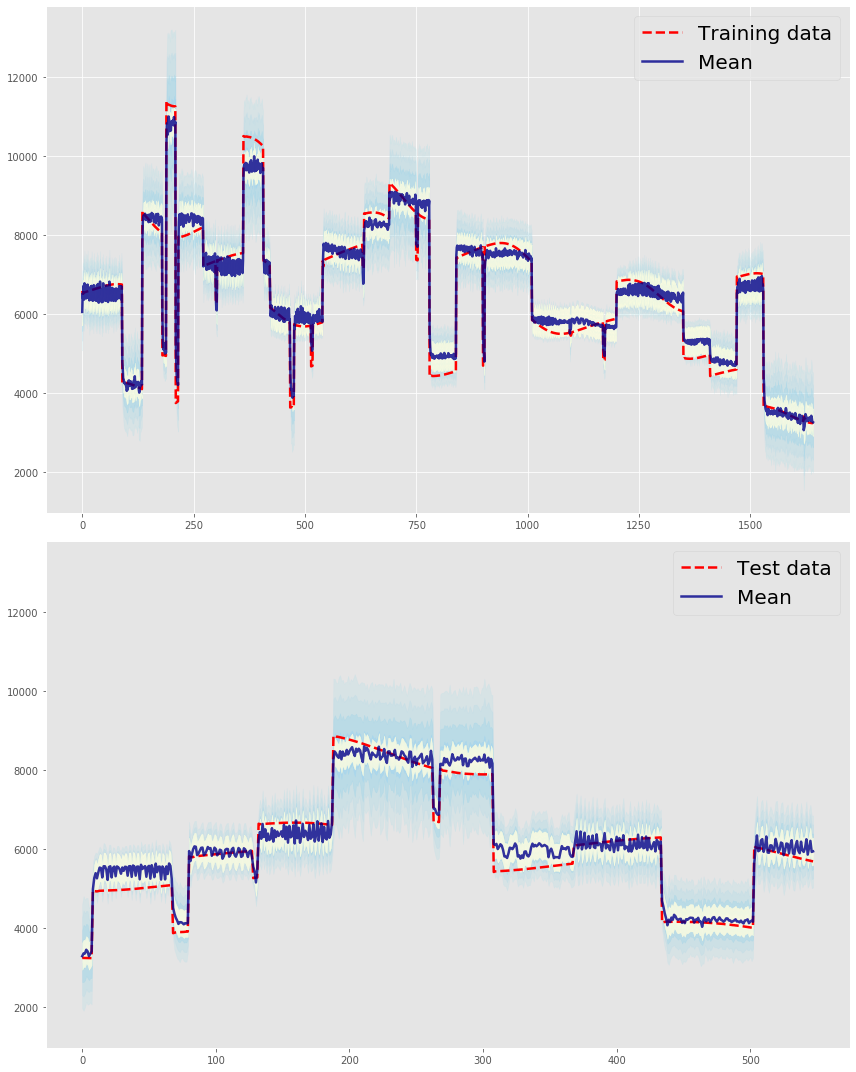

In [217]:
plot_BBP(x_train_plot.ravel(), Y_train.ravel(), x_test_plot.ravel(), 
         Y_test.ravel(), means_train.ravel(), means_test.ravel(),
         aleatoric_train, epistemic_train.ravel(), total_unc_train.ravel(), 
         aleatoric_test, epistemic_test.ravel(), total_unc_test.ravel())